In [39]:
# Importing required libraries
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

In [40]:
# Connection to google drive for data
from google.colab import drive
drive = drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install split-folders

In [ ]:
#Split the train images and masks into training and validation set 
import splitfolders
splitfolders.fixed("/content/drive/MyDrive/FoundationDeepLearning_Labs/Kaggle_Project/Input", "/content/drive/MyDrive/FoundationDeepLearning_Labs/Kaggle_Project/Input_Split", 
                   seed = 1337, fixed = (30), oversample = False, group_prefix = None)

Copying files: 522 files [00:57,  9.08 files/s]


# Dataset Preparation 

In [41]:
# Directories in google drive where images are present.
train_images_dir = '/content/drive/MyDrive/FoundationDeepLearning_Labs/Kaggle_Project/Input/train_images/'
train_masks_dir = '/content/drive/MyDrive/FoundationDeepLearning_Labs/Kaggle_Project/Input/train_masks'
#val_images_dir = '/content/drive/MyDrive/FoundationDeepLearning_Labs/Kaggle_Project/Input_Split/val/train_images'
#val_masks_dir = '/content/drive/MyDrive/FoundationDeepLearning_Labs/Kaggle_Project/Input_Split/val/train_masks'
test_images_dir = '/content/drive/MyDrive/FoundationDeepLearning_Labs/Kaggle_Project/test_images/test_images/'

In [42]:
# Class for Train Dataset Preparation - 
class KaggleDataset(Dataset):
  def __init__(self, image_dir, mask_dir, transform = None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img_path = os.path.join(self.image_dir, self.images[index])
    mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", ".png"))
    image = np.array(Image.open(img_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"), dtype = np.float32)

    if self.transform is not None:
      augmentations = self.transform(image=image, mask = mask)
      image = augmentations["image"]
      mask = augmentations["mask"]

    return image, mask

In [43]:
#Class for Test Dataset Preparation - 
class KaggleTestDataset(Dataset):
  def __init__(self, image_dir, transform = None):
    self.image_dir = image_dir
    self.transform = transform
    self.images = os.listdir(image_dir)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img_path = os.path.join(self.image_dir, self.images[index])
    image = np.array(Image.open(img_path).convert("RGB"))

    if self.transform is not None:
      augmentations = self.transform(image=image)
      image = augmentations["image"]

    return image

In [6]:
# Install the latest version of Albumentations for data transformation - 
!pip install albumentations==0.4.6

     |████████████████████████████████| 117 kB 7.2 MB/s 
     |████████████████████████████████| 948 kB 55.2 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=e735882381e4e56bcfc87d53c753ee91544b9a953b494ff3ec824e7672355eca
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [56]:
# Transformations on train and test dataset - 

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torchvision import transforms

Image_height = 128
Image_width = 128

transforms = A.Compose(
    [
     A.Resize(height=Image_height, width=Image_width),
     #A.Rotate(limit=35, p=1.0),
     #A.HorizontalFlip(p=0.5),
     #A.VerticalFlip(p=0.1),
    #  A.Normalize(
    #      mean=[0.0, 0.0, 0.0],
    #      std = [1.0, 1.0, 1.0],
    #      max_pixel_value = 255.0,
    # ),
     ToTensorV2(),
    ],
)

test_transform = A.Compose(
    [
     A.Resize(height=Image_height, width = Image_width),
    #  A.Normalize(
    #      mean=[0.0, 0.0, 0.0],
    #      std = [1.0, 1.0, 1.0],
    #      max_pixel_value = 255.0
    #  ),
     ToTensorV2(),
    ],
)

In [61]:
# Train, Validation and Test Dataloader for model training and evaluation - 

from torch.utils.data import DataLoader

train_ds = KaggleDataset(image_dir=train_images_dir, mask_dir = train_masks_dir, transform=transforms)
train_dataloader = DataLoader(train_ds, batch_size= 16, num_workers= 2, shuffle=True)

#val_ds = KaggleDataset(image_dir=val_images_dir, mask_dir = val_masks_dir, transform=transforms)
#val_dataloader = DataLoader(train_ds, batch_size= 16, num_workers= 2, shuffle=False)

test_ds = KaggleTestDataset(image_dir=test_images_dir, transform=test_transform)
test_dataloader = DataLoader(test_ds, batch_size=1, num_workers = 2, shuffle=False) #Keeping the batch size of 1 for test images.


In [62]:
# Check on the dimensions of batch in train_dataloader
image, mask = next(iter(train_dataloader))
print(image.shape)
print(mask.shape)

torch.Size([16, 3, 128, 128])
torch.Size([16, 128, 128])


In [10]:
# # Check on the dimensions of batch in val_dataloader
# image, mask = next(iter(val_dataloader))
# print(image.shape)
# print(mask.shape)

torch.Size([8, 3, 256, 256])
torch.Size([8, 256, 256])


In [63]:
# Check on the dimensions of batch in test_dataloader
image = next(iter(test_dataloader))
print(image.shape)

torch.Size([1, 3, 128, 128])


# UNET Model Architecture - 

In [48]:
import torch.nn as nn
import torch
from torch import autograd

class DoubleConv(nn.Module):
  def __init__(self, in_ch, out_ch):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_ch, out_ch, 3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_ch, out_ch, 3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace = True)
    )

  def forward(self, input):
    return self.conv(input)

class UNet(nn.Module):
  def __init__(self, in_ch, out_ch):
    super(UNet, self).__init__()

    self.conv1 = DoubleConv(in_ch, 64)
    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = DoubleConv(64, 128)
    self.pool2 = nn.MaxPool2d(2)
    self.conv3 = DoubleConv(128, 256)
    self.pool3 = nn.MaxPool2d(2)
    self.conv4 = DoubleConv(256, 512)
    self.pool4 = nn.MaxPool2d(2)
    self.conv5 = DoubleConv(512, 1024)

    self.up6 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
    self.conv6 = DoubleConv(1024, 512)
    self.up7 = nn.ConvTranspose2d(512, 256, 2, stride=2)
    self.conv7 = DoubleConv(512, 256)
    self.up8 = nn.ConvTranspose2d(256, 128, 2, stride=2)
    self.conv8 = DoubleConv(256, 128)
    self.up9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
    self.conv9 = DoubleConv(128, 64)
    self.conv10 = nn.Conv2d(64, out_ch, 1)

  def forward(self, x):
    c1 = self.conv1(x)
    p1 = self.pool1(c1)
    c2 = self.conv2(p1)
    p2 = self.pool2(c2)
    c3 = self.conv3(p2)
    p3 = self.pool3(c3)
    c4 = self.conv4(p3)
    p4 = self.pool4(c4)
    c5 = self.conv5(p4)

    up_6 = self.up6(c5)
    merge6 = torch.cat([up_6, c4], dim=1)
    c6 = self.conv6(merge6)
    up_7 = self.up7(c6)
    merge_7 = torch.cat([up_7, c3], dim=1)
    c7 = self.conv7(merge_7)
    up_8 = self.up8(c7)
    merge8 = torch.cat([up_8, c2], dim=1)
    c8 = self.conv8(merge8)
    up_9 = self.up9(c8)
    merge9 = torch.cat([up_9, c1], dim=1)
    c9 = self.conv9(merge9)
    c10 = self.conv10(c9)
    return c10
    

# Training the UNet

In [60]:
# Check on the device
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

Using device: cuda


In [64]:
# Model Parameters - 
lr = 0.0001
model = UNet(in_ch=3, out_ch=25).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
epochs = 40

In [ ]:
# Model training and validation using above defined parameters - 

import numpy as np
from tqdm import tqdm
save_folder = '/content/drive/MyDrive/FoundationDeepLearning_Labs/Kaggle_Project/Trained_Models_Itr2/'

total_train_loss = []
total_val_loss = []

for epoch in range(1, epochs+1):

  #Training
  model.train()
  train_loss = []
  #confusion_matrix.reset()

  for i, batch, in enumerate(tqdm(train_dataloader)):
    img_batch, lbl_batch = batch
    img_batch, lbl_batch = img_batch.to(device), lbl_batch.type(torch.LongTensor).to(device)
  
    optimizer.zero_grad()
    output = model(img_batch.float())
    loss = criterion(output, lbl_batch)
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())
    

    if i%50 == 0:
      print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, epochs, i, len(train_dataloader), 100.*i/len(train_dataloader), loss.item()
      ))

  train_loss_mean = np.mean(train_loss)
  total_train_loss.append(train_loss_mean)
  

  #Validation 
  # model.eval()
  # val_loss = []

  # for i, batch, in enumerate(tqdm(val_dataloader)):
  #   img_batch, lbl_batch = batch
  #   img_batch, lbl_batch = img_batch.to(device), lbl_batch.type(torch.LongTensor).to(device)

  #   output = model(img_batch.float())
  #   loss = criterion(output, lbl_batch)

  #   val_loss.append(loss.item())

  # val_loss_mean = np.mean(val_loss)
  # total_val_loss.append(val_loss_mean)
  

  print('Train_Loss: ', '%.3f' % train_loss_mean)
  #print('Val_Loss: ', '%.3f' % val_loss_mean)

  torch.save(model.state_dict(), save_folder + 'model_{}.pt'.format(epoch))


  6%|▌         | 1/17 [00:08<02:11,  8.25s/it]

Train (epoch 1/40) [0/17 (0%)]	Loss: 3.290451


100%|██████████| 17/17 [01:03<00:00,  3.71s/it]


Train_Loss:  2.910


  6%|▌         | 1/17 [00:08<02:12,  8.29s/it]

Train (epoch 2/40) [0/17 (0%)]	Loss: 2.593616


100%|██████████| 17/17 [01:03<00:00,  3.71s/it]


Train_Loss:  2.391


  6%|▌         | 1/17 [00:08<02:13,  8.34s/it]

Train (epoch 3/40) [0/17 (0%)]	Loss: 2.230849


100%|██████████| 17/17 [01:02<00:00,  3.68s/it]


Train_Loss:  2.166


  6%|▌         | 1/17 [00:07<02:06,  7.89s/it]

Train (epoch 4/40) [0/17 (0%)]	Loss: 2.061323


100%|██████████| 17/17 [01:02<00:00,  3.66s/it]


Train_Loss:  2.038


  6%|▌         | 1/17 [00:08<02:11,  8.20s/it]

Train (epoch 5/40) [0/17 (0%)]	Loss: 1.877487


100%|██████████| 17/17 [01:02<00:00,  3.68s/it]


Train_Loss:  1.953


  6%|▌         | 1/17 [00:08<02:09,  8.12s/it]

Train (epoch 6/40) [0/17 (0%)]	Loss: 1.913936


100%|██████████| 17/17 [01:03<00:00,  3.72s/it]


Train_Loss:  1.825


  6%|▌         | 1/17 [00:08<02:12,  8.25s/it]

Train (epoch 7/40) [0/17 (0%)]	Loss: 1.770752


100%|██████████| 17/17 [01:02<00:00,  3.69s/it]


Train_Loss:  1.755


  6%|▌         | 1/17 [00:08<02:09,  8.07s/it]

Train (epoch 8/40) [0/17 (0%)]	Loss: 1.737635


100%|██████████| 17/17 [01:02<00:00,  3.69s/it]


Train_Loss:  1.677


  6%|▌         | 1/17 [00:08<02:08,  8.01s/it]

Train (epoch 9/40) [0/17 (0%)]	Loss: 1.591150


100%|██████████| 17/17 [01:02<00:00,  3.68s/it]


Train_Loss:  1.635


  6%|▌         | 1/17 [00:08<02:12,  8.29s/it]

Train (epoch 10/40) [0/17 (0%)]	Loss: 1.638770


100%|██████████| 17/17 [01:03<00:00,  3.72s/it]


Train_Loss:  1.577


  6%|▌         | 1/17 [00:08<02:15,  8.49s/it]

Train (epoch 11/40) [0/17 (0%)]	Loss: 1.519755


100%|██████████| 17/17 [01:02<00:00,  3.70s/it]


Train_Loss:  1.527


  6%|▌         | 1/17 [00:08<02:13,  8.35s/it]

Train (epoch 12/40) [0/17 (0%)]	Loss: 1.418302


100%|██████████| 17/17 [01:02<00:00,  3.70s/it]


Train_Loss:  1.465


  6%|▌         | 1/17 [00:08<02:13,  8.34s/it]

Train (epoch 13/40) [0/17 (0%)]	Loss: 1.396742


100%|██████████| 17/17 [01:03<00:00,  3.73s/it]


Train_Loss:  1.398


  6%|▌         | 1/17 [00:08<02:11,  8.24s/it]

Train (epoch 14/40) [0/17 (0%)]	Loss: 1.329883


100%|██████████| 17/17 [01:02<00:00,  3.70s/it]


Train_Loss:  1.364


  6%|▌         | 1/17 [00:08<02:10,  8.17s/it]

Train (epoch 15/40) [0/17 (0%)]	Loss: 1.282211


 53%|█████▎    | 9/17 [00:39<00:36,  4.56s/it]

Text(0, 0.5, 'Loss')

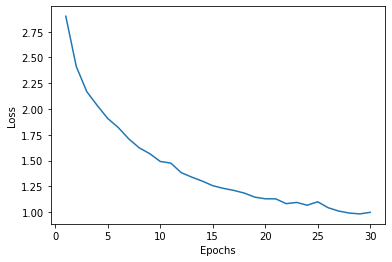

In [52]:
#Training and Validation Loss Curve

import matplotlib.pyplot as plt

plt.plot(list(range(epochs+1))[1:], total_train_loss)
#plt.plot(list(range(epochs+1))[1:], total_val_loss)
#plt.legend(['train','val'])
plt.xlabel('Epochs')
plt.ylabel('Loss')


# Output on Test Images

In [53]:
#List of the names of images from test dataset - 

import pandas as pd
def create_df():
    name = []
    for dirname, _, filenames in os.walk(test_images_dir):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df_test = create_df()
print('Total Images: ', len(df_test))

test = df_test['id'].values

Total Images:  112


In [54]:
# Running the most optimal epoch on test images for mask output

import torch.nn.functional as F
import cv2
from PIL import Image

model = UNet(3, 27)
model.load_state_dict(torch.load('/content/drive/MyDrive/FoundationDeepLearning_Labs/Kaggle_Project/Trained_Models_Itr2/model_29.pt'))

# Directory for saving the output masks
save_path = '/content/drive/MyDrive/FoundationDeepLearning_Labs/Kaggle_Project/test_preds_itr2/'

model.eval()

i = 0
with torch.no_grad():
  for x in test_dataloader:
    y = model(x.float())

    y = F.softmax(y, dim=1) # Convert the network output values to probabilistic array [1x25x128x128]
    y = torch.argmax(y, dim=1) # take the index corresponding to larger value [1x1x128x128]
    
    y = y.cpu().squeeze(0)

    mask = y.detach().numpy().copy()

    resize = A.Resize(4000, 3000, interpolation=cv2.INTER_NEAREST)
    aug = resize(image = mask)
    mask = aug['image']

    # Save the mask image as .png file
    cv2.imwrite(save_path + str(test[i]) + '.png', mask)
    
    i = i+1

# Submission file using the prepare_submssion.py code

In [55]:
import os

from PIL import Image
import numpy as np

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def create_rles():
    """Used for Kaggle submission: predicts and encode all test images"""
    dir = save_path
    N = len(list(os.listdir(dir)))
    with open('submission_file.csv', 'w') as f: 
        f.write('ImageClassId,rle_mask\n')
        for index, i in enumerate(os.listdir(dir)):
            # print('{}/{}'.format(index, N))

            mask = Image.open(dir + i)
            mask = mask.resize((1024, 1024), resample=Image.NEAREST) #Image.BICUBIC
            mask = np.array(mask)

            for x in range(1, 25):
                enc = rle_encode(mask == x)
                f.write(f"{i.split('_')[0]}_{x},{enc}\n")

create_rles()